In [1]:
from functions.load_all_data import load_imgs_masks
from functions.composites import composite_masks
from functions.crop_image import random_crop
from functions.rescaling import rescale_img_comp
from functions.sizes import compute_avg_size
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Configure Variables Here! 
* Anywhere a number is set by hand, make it a variable

In [2]:
BINS = 75
TARGET_RANGE = 396 # Multiples of 39.653333
CROP_SIZE = 128
n_crops = 1000
n_samples = n_crops // BINS

In [3]:
n_samples

13

# Purpose: Augment Images and Mask Composites for Regression Model
* Scale images to match their bin and to 10 bins above and below it
* Generate more crops for bins with less samples
* Plot distribution of sizes after these transformations
* ideally, sizes should be uniformly distributed

In [4]:
all_imgs, mask_colls = load_imgs_masks()[:2]
mask_comps = []
nuclei_sizes = []

start = time.time()
for mask in mask_colls:
    curr_comp = composite_masks(mask)
    curr_size = compute_avg_size(curr_comp)
    
    mask_comps.append(curr_comp)
    nuclei_sizes.append(curr_size)

end = time.time() - start
print("Composites created in %d minutes, %.2f seconds"
     %((end // 60), end % 60))

Composites created in 1 minutes, 5.07 seconds


In [35]:
min_x, min_y = 10000, 10000
for i in range(670):
    if all_imgs[i].shape[0] < min_x:
        min_x = all_imgs[i].shape[0]
    if all_imgs[i].shape[1] < min_y:
        min_y = all_imgs[i].shape[1]
print(min_x, min_y)

256 256


39.653333333333336

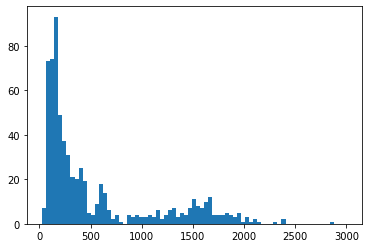

In [5]:
n, bins, patches = plt.hist(nuclei_sizes, bins=BINS, range=(np.min(nuclei_sizes), 3000))
bins[1] - bins[0]

In [6]:
sizes_comps_imgs = np.array((nuclei_sizes, mask_comps, all_imgs), order='F')
ind = sizes_comps_imgs[0, :].argsort(axis=0)
sizes_comps_imgs[0] = sizes_comps_imgs[0][ind]
sizes_comps_imgs[1] = sizes_comps_imgs[1][ind]
sizes_comps_imgs[2] = sizes_comps_imgs[2][ind]

# Improved Data Augmentation
* include parameters for number of crops (n), bins (b)
    * compute how many examples we need for each bin (n / b)
* make sure that each image has all properties that we care about:
    * size 128x128 (prioritize this)
    * within 10 bins of original object size
    * check number of images for specific bin 
    * maybe: check images BEFORE rescaling to check which images are compatible with which bin and store in a dictionary
        * check this dictionary when rescaling and then figure out how many crops are necessary for each bin
* if there are less images than desired crops, take the same number of crops for each image
* Largest image needs more attention
    * Rescale it, take a few random crops of the rescaled images

In [7]:
start = time.time()
to_rescale = dict()

for i in range(BINS):
    target_size = bins[i]
    to_rescale[i] = []
    for j in range(669):
        comp = sizes_comps_imgs[1][j]
        curr_size = sizes_comps_imgs[0][j]

        ratio = target_size / curr_size
        ratio = ratio ** (1/2)
        
        # ensure that rescaled image will fit inside crop
        if min(int(comp.shape[0] * ratio),
               int(comp.shape[1] * ratio)) < CROP_SIZE:
            continue
        
        # ensure we only rescale images to within 10 bins of their original size
        else:
            if abs(curr_size - target_size) < (bins[1] - bins[0]) * 10:
                to_rescale[i].append(j)

end = time.time() - start
print("Compatibility calculated in %d minutes, %.2f seconds"
     %((end // 60), end %60))

Compatibility calculated in 0 minutes, 0.21 seconds


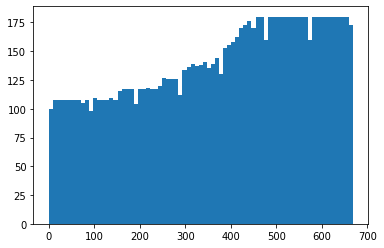

In [8]:
flat_list = []
for key in to_rescale:
    for sublist in to_rescale[key]:
        flat_list.append(sublist)

n_new, bins_new, patches = plt.hist(flat_list, bins=BINS)

In [9]:
start = time.time()
rescaled_data = dict()

for key in to_rescale:
    target_size = bins[key]
    rescaled_data[key] = []
    
    for index in to_rescale[key]:
        curr_comp = sizes_comps_imgs[1][index]
        curr_img = sizes_comps_imgs[2][index]
        
        rescaled_img, rescaled_comp = rescale_img_comp(curr_img, curr_comp,
                                                      target_size)
        rescaled_size = compute_avg_size(rescaled_comp)
        
        rescaled_data[key].append((rescaled_size, rescaled_comp, rescaled_img))
                
end = time.time() - start
print("Data rescaled in %d minutes, %.2f seconds"
     %((end // 60), end % 60))

Data rescaled in 9 minutes, 12.27 seconds


In [10]:
count = 0
for key in rescaled_data:
    count += len(rescaled_data[key])
count

10673

107


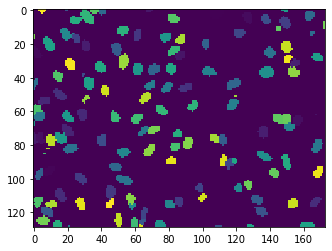

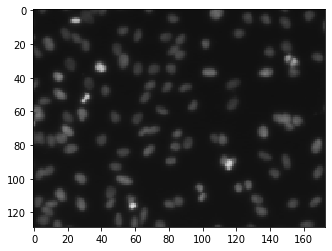

In [28]:
print(len(rescaled_data[0]))
plt.imshow(rescaled_data[0][106][1]); plt.figure()
plt.imshow(rescaled_data[0][106][2])

In [12]:
rescaled_sizes = []
curr_sizes = []
for key in rescaled_data:
    for triad in rescaled_data[key]:
        curr_size = triad[0]
        curr_sizes.append(curr_size)
        
    rescaled_sizes.append(curr_sizes)
    curr_sizes = []

rescaled_sizes = [item for sublist in rescaled_sizes for item in sublist]

array([111., 357., 446., 453., 466., 484., 499., 504., 507., 512., 509.,
       506., 435., 365., 276., 230., 196., 169., 151., 137., 114.,  99.,
       100., 103.,  97.,  84.,  74.,  75.,  84.,  88.,  94., 104., 112.,
       113., 113., 114., 116., 116., 115., 116., 113., 114., 107., 101.,
       102.,  92.,  92.,  84.,  69.,  64.,  53.,  62.,  37.,  37.,  34.,
        25.,  25.,  22.,  17.,  14.,  13.,   8.,   7.,   7.,   3.,   4.,
         4.,   4.,   4.,   4.,   2.,   1.,   1.,   1.,   2.])

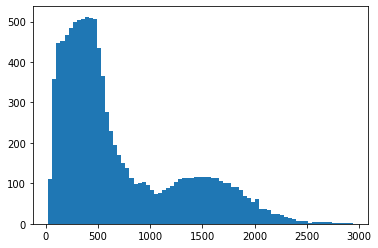

In [13]:
n_rescaled, bins_rescaled, patches = plt.hist(rescaled_sizes, bins=BINS)
n_rescaled

646.5367901234569


659.6987951807229

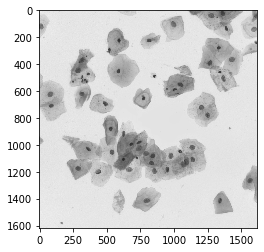

In [15]:
plt.imshow(rescaled_data[16][0][2])
print(bins_rescaled[16])
rescaled_data[16][0][0]

In [32]:
[y[0] for y in rescaled_data[67]]

[2673.5882352941176, 2668.3636363636365, 2679.8, 2674.4117647058824]

In [16]:
cropped_data = dict()
missing_samples = [n_samples for i in range(BINS)]
i = 0
cropped_data[i] = []
start = time.time()

while np.sum(missing_samples) != 0:
    if missing_samples[i] != 0:
        curr_bin = rescaled_data[i]
        rand_index = np.random.randint(0, len(curr_bin))
        
        while True:
            cropped_img, cropped_mask = random_crop(img=curr_bin[rand_index][2],
                                                    mask_composite=curr_bin[rand_index][1],
                                                    crop_size=CROP_SIZE)
            cropped_size = compute_avg_size(cropped_mask)
            if cropped_size > 0:
                cropped_data[i].append((cropped_size, cropped_mask, cropped_img))
                break
                
        missing_samples[i] -= 1
    else:
        i += 1
        cropped_data[i] = []
        
end = time.time() - start
print("Data cropped in %d minutes, %.2f seconds" 
     %((end // 60), end % 60))

Data cropped in 0 minutes, 0.72 seconds


In [17]:
count = 0
for key in cropped_data:
    count += len(cropped_data[key])
print(count)

975


In [30]:
[x[0] for x in cropped_data[67]]

[1982.6666666666667,
 1064.0,
 628.0,
 1433.5,
 2646.5,
 1005.6666666666666,
 1130.2,
 2732.5,
 1462.142857142857,
 941.0,
 2760.0,
 2565.0,
 2013.25]

In [33]:
[x[0] for x in cropped_data[20]]

[1310.2857142857142,
 589.4444444444445,
 313.6666666666667,
 378.0,
 485.6,
 596.8461538461538,
 695.6666666666666,
 342.2,
 548.6666666666666,
 463.42857142857144,
 817.5,
 500.0,
 675.1666666666666]

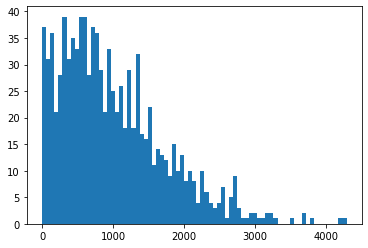

In [18]:
flat_list = []
for key in cropped_data:
    for triad in cropped_data[key]:
        flat_list.append(triad[0])
n_cropped, bins_cropped, patches = plt.hist(flat_list, bins=BINS)

In [21]:
np.sum(n_cropped)

975.0

In [20]:
np.sum(missing_samples)

0

In [24]:
cropped_sizes = []
cropped_comps = []
cropped_imgs = []
for key in cropped_data:
    for triad in cropped_data[key]:
        cropped_sizes.append(triad[0])
        cropped_comps.append(triad[1])
        cropped_imgs.append(triad[2])

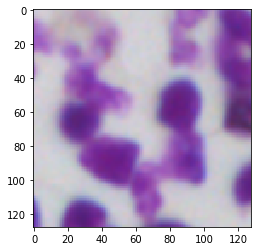

In [26]:
plt.imshow(cropped_imgs[200])

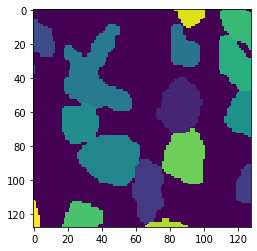

In [27]:
plt.imshow(cropped_comps[200])